In [164]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.float_format', '{:.3f}'.format)
# and numpy
np.set_printoptions(suppress=True, precision=5)

In [165]:
data = pd.read_csv('final_data.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [166]:
print(data.columns.to_list())

['att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Sabotage Equipment', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent

In [167]:
hhh = data.copy()

In [168]:
data= data.dropna(subset='nkill')

In [169]:
data['letal'] = data['nkill'].apply(lambda x:1 if x !=0 else 0)

In [170]:
data['nkill']

0        1.000
1        0.000
2        1.000
5        0.000
6        0.000
          ... 
209699   0.000
209700   0.000
209703   0.000
209704   1.000
209705   5.000
Name: nkill, Length: 197179, dtype: float64

In [171]:
data['letal']

0         1
1         0
2         1
5         0
6         0
         ..
209699    0
209700    0
209703    0
209704    1
209705    1
Name: letal, Length: 197179, dtype: int64

In [172]:
data['weap_cbr'] = data['weap_Chemical'] + data['weap_Biological'] + data['weap_Radiological']

In [173]:
new_drop = ['targ_Airports & Aircraft','targ_Educational Institution','att_Assassination','targ_Violent Political Party','weap_cbr','v2x_clphy','targ_Other','targ_Maritime','targ_Abortion Related','weap_Sabotage Equipment','targ_Government (General)','weap_Chemical','weap_Biological','weap_Radiological','v2x_ex_military','reg_South America','reg_Central Asia','targ_Telecommunication','weap_Other','reg_Central America & Caribbean','weap_Fake Weapons']

to_drop = ['success','reg_Southeast Asia','reg_East Asia','country_txt','year','eventid','gname','nkill','motive'] + new_drop + ['v2clsnlpct', 'Population', 'Net migration', 'Births from mothers aged 15 to 19 years', 'Population density','targ_Food or Water Supply']
df=data.drop(columns=to_drop)

In [174]:
df = df.dropna(axis=0, how='any')
print(len(df))

196524


In [175]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()



In [176]:
X = df.drop(columns='letal')
Y = df['letal']
X_with_intercept = sm.add_constant(X)

In [177]:
X2=X

In [178]:
scaler.fit(X2)
X2 = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [179]:
X2.to_csv('logi_dat.csv')
Y.to_csv('logi_Y.csv')

In [180]:
test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
scaler.fit(X_test)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_with_intercept = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

X_train shape: (137566, 40), y_train shape: (137566,)
X_test shape: (58958, 40), y_test shape: (58958,)


In [181]:
# Fit the model 
model = sm.Logit(y_train, X_with_intercept).fit(maxiter=1000)


Optimization terminated successfully.
         Current function value: 0.497268
         Iterations 7


In [182]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  letal   No. Observations:               137566
Model:                          Logit   Df Residuals:                   137525
Method:                           MLE   Df Model:                           40
Date:                Fri, 19 Apr 2024   Pseudo R-squ.:                  0.2826
Time:                        20:38:49   Log-Likelihood:                -68407.
converged:                       True   LL-Null:                       -95351.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                 

In [183]:
# Define the intercept and coefficient for suicide from your model
intercept = 0.2580
coef = 0.7179      
indi = 0.0782

# Calculate z for a suicide attack
z_su = intercept + coef * 1 

# Calculate the probability that the attack is lethal
prob_lethal = 1 / (1 + np.exp(-z_su))

print(f"Probability that a suicide attack is lethal: {prob_lethal:.2f}")


Probability that a suicide attack is lethal: 0.73


In [184]:
simulations_df = pd.DataFrame(model.params)
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')
tresholdd=0.01

In [185]:
mask=simulations_df<tresholdd
ggg=simulations_df[mask]
mask2 = ggg>-tresholdd
gg44=ggg[mask2]

In [186]:
lista = gg44.dropna()
print(lista.index.to_list())

['targ_NGO']


In [187]:
beta_mean = model.params
beta_cov = model.cov_params()

n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

simulated_betas_odds = np.exp(simulated_betas)

In [188]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

C:\Users\lucab\AppData\Local\Temp\ipykernel_21248\3004529438.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


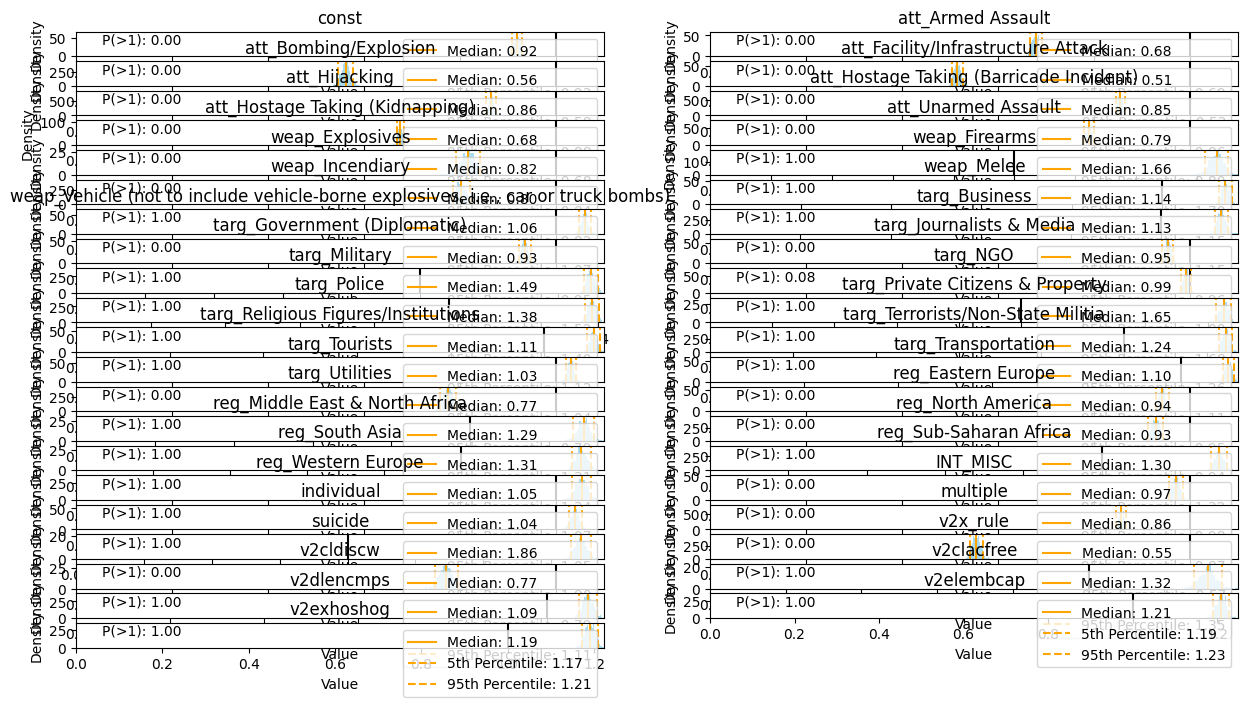

In [189]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [190]:
list_aic = []


In [191]:

aic = model.aic
list_aic.append((model,aic))
print("AIC:", aic)

AIC: 136896.27647480942


In [192]:
print(list_aic)

[(<statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000019CA52AD6D0>, 136896.27647480942)]


In [193]:
predictions = model.predict(X_test_const)
binary_predictions = np.where(predictions > 0.5, 1, 0)

In [194]:
y_test

144383    0
158052    1
109846    0
67307     1
44316     0
         ..
37772     0
119809    0
12811     0
99676     0
163383    0
Name: letal, Length: 58958, dtype: int64

In [195]:
predictions

144383   0.601
158052   0.894
109846   0.419
67307    0.754
44316    0.026
          ... 
37772    0.207
119809   0.041
12811    0.179
99676    0.210
163383   0.293
Length: 58958, dtype: float64

Accuracy: 0.7641


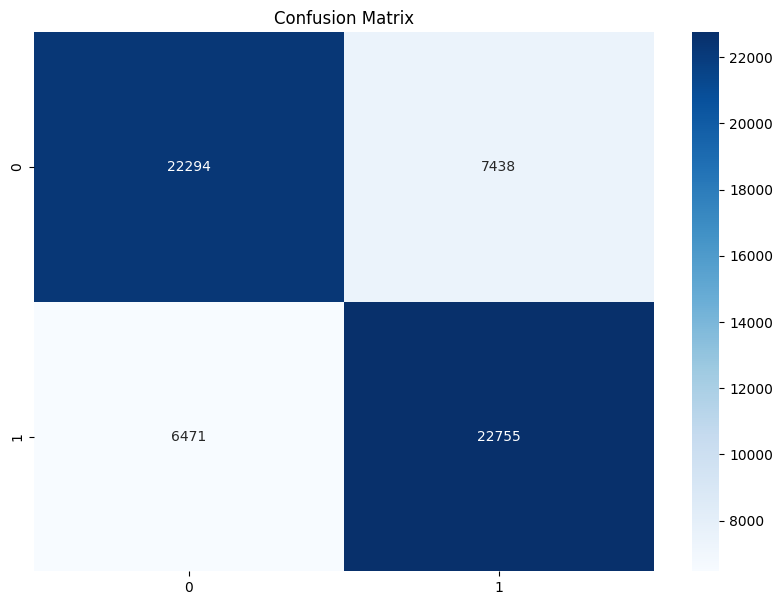

In [196]:
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [197]:
conf_matrix

array([[22294,  7438],
       [ 6471, 22755]], dtype=int64)

In [198]:
score = brier_score_loss(y_test,predictions)
print("Brier score:", score)

Brier score: 0.16171892556135872
